# IEEE eScience paper

Compare stances over time derived from tweets with stances from other sources, for example RIVM behavioral studies.

This notebook reuses code from the notebooks:
* domain-adaptation.ipynb
* fasttext.ipynb
* tweet-counts.ipynb

RIVM measures that were evaluated:
* Naleving gedragsregels / Houden aan gedragsregels / Voldoende afstand houden van anderen
* Naleving gedragsregels / Houden aan gedragsregels / Mondkapje in publieke binnenruimten
* Naleving gedragsregels / Testen / Klachten totaal (from point 12, May 2021: testen met klachten)
* Vaccinatiebereidheid / Totaal
* Naleving gedragsregels / Houden aan gedragsregels / Avondklok niet naar buiten geweest

## 1. Read data

In [1]:
from nltk.tokenize import TweetTokenizer
import pandas as pd
import re

In [2]:
DATA_DIR = "../data/"
ANNOTATION_DIR = DATA_DIR + "annotation/"
CURFEW = "curfew"
DISTANCE = "distance"
DISTANCE1000 = "distance1000"
FACEMASK = "mondkapje"
TESTING = "testing"
VACCINATION = "vaccin"
WORKFROMHOME = "work-from-home"
TOPICS = [ CURFEW, DISTANCE, FACEMASK, TESTING, VACCINATION, WORKFROMHOME ]
IDSTR = "id_str"
IRRELEVANT = "ANDERS"
TOTAL = "total"

In [3]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

In [4]:
def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

In [5]:
def preprocess(text):
    return(tokenize(cleanup(text)).lower())

In [6]:
def select_annotations(annotations_in, tweets, main_annotator):
    annotations_out = {}
    for i, row in annotations_in.iterrows():
        if row[0]== main_annotator:
            id_str = row[2]
            label = row[4]
            if id_str in tweets.index:
                annotations_out[id_str] = { "label": label, "text": preprocess(tweets.loc[id_str]["text"]) }
    return annotations_out

In [7]:
def read_data_topic(topic):
    if topic == TESTING:
        tweet_file = ANNOTATION_DIR + topic + "-202003-202012.csv"
    elif topic == FACEMASK:
        tweet_file = ANNOTATION_DIR + topic + "-202003-202103-1000.csv"
    elif topic == VACCINATION:
        tweet_file = ANNOTATION_DIR + topic + "-202001-202105.csv"
    elif topic == CURFEW:
        tweet_file = ANNOTATION_DIR + topic + "-202003-202105.csv"
    elif topic == WORKFROMHOME:
        tweet_file = ANNOTATION_DIR + topic + "-202003-202105.csv"
    elif topic == DISTANCE:
        tweet_file = DATA_DIR + topic + "-tweets.csv"
    else:
        print(f"read_fasttext_data: unknown topic: {topic}")
    tweets = pd.read_csv(tweet_file, index_col=IDSTR)
    annotations = pd.read_csv(tweet_file + ".human-labels.txt", header=None, sep=" ")
    main_annotator = annotations.iloc[0][0]
    annotations = select_annotations(annotations, tweets, main_annotator)
    return annotations, main_annotator

In [8]:
def store_annotations(annotations, topic):
    pd.DataFrame([[key, annotations[key]["label"]] for key in annotations], columns=["id_str", "label"]).to_csv(f"data-{topic}.csv", 
                                                                                                                index=False)

In [9]:
def read_all_data(topics):
    annotations = {}
    for topic in topics:
        if topic != DISTANCE1000:
            annotations[topic], main_annotator = read_data_topic(topic)
            print(f"read topic {topic}: {len(annotations[topic])} annotations from {main_annotator}")
    return annotations

In [10]:
annotations = read_all_data(TOPICS+[DISTANCE])

read topic curfew: 750 annotations from erikt@xs4all.nl
read topic distance: 5977 annotations from erikt@xs4all.nl
read topic mondkapje: 1011 annotations from erikt@xs4all.nl
read topic testing: 1181 annotations from erikt@xs4all.nl
read topic vaccin: 1340 annotations from erikt@xs4all.nl
read topic work-from-home: 1003 annotations from erikt@xs4all.nl
read topic distance: 5977 annotations from erikt@xs4all.nl


In [11]:
annotations[DISTANCE1000] = {}
counter = 0
for key in annotations[DISTANCE]:
    if counter % 5 == 0:
        annotations[DISTANCE1000][key] = annotations[DISTANCE][key]
    counter += 1
len(annotations[DISTANCE1000])

1196

## 2. Run fastText

In [12]:
import fasttext
import json
import os
import sys
import tempfile

In [13]:
TEXT = "text"
TEXT_DIR = DATA_DIR + "text/"
CURFEW_QUERY = "avondklok"
DISTANCE_QUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
FACEMASK_QUERY = "mondkapje"
TEST_QUERY = r'\btest|getest|sneltest|pcr'
VACCIN_QUERY = "vaccin|ingeënt|ingeent|inent|prik|spuit|bijwerking|-->|💉|pfizer|moderna|astrazeneca|astra|zeneca|novavax|biontech"
WORKFROMHOME_QUERY = "(thuiswerk|thuis.werk|werk.thuis)"
RIVM_ROUNDS_ORG = [ "^2020041[7-9]|^2020042[0-4]", "^2020050[7-9]|^2020051[0-2]", "^2020052[7-9]|^2020053|^20200601", "^2020061[7-9]|^2020062[0-1]",
                    "^2020070[8-9]|^2020071[0-2]", "^20200819|^2020082[0-3]",     "^20200930|^2020100[1-4]",          "^2020111[1-5]",
                    "^2020123|^2021010[1-3]",      "^2021021[0-4]",               "^2021032[4-8]",                    "^2021050[5-9]" ]
RIVM_MONTHS_ORG = [ "Apr", "May", "", "Jun", "Jul", "Aug", "Sep", "Nov", "Jan", "Feb", "Mar", "May" ]
RIVM_COUNTS_ORG = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ]
RIVM_ROUNDS = [ "^2021061[6-9]|^20210620", "^2021072[89]|^2021073|^20210801", "^2021090[89]|2021091[0-2]", "^2021102[0-4]", "^2021112[4-8]", ]
RIVM_MONTHS = [ "Jun", "Jul", "Sep", "Oct", "Nov", ]
RIVM_COUNTS = [ 13, 14, 15, 16, 17, ]
QUERIES = { CURFEW: CURFEW_QUERY, DISTANCE: DISTANCE_QUERY, DISTANCE1000: DISTANCE_QUERY, FACEMASK: FACEMASK_QUERY, 
            TESTING: TEST_QUERY, VACCINATION: VACCIN_QUERY, WORKFROMHOME: WORKFROMHOME_QUERY }

In [14]:
def read_data_fasttext(date_pattern, query, data_directory=TEXT_DIR):
    file_list = sorted(os.listdir(data_directory))
    test_data = []
    hours = 0
    for in_file_name in file_list:
        if re.search(date_pattern, in_file_name) and os.path.exists(data_directory + in_file_name):
            try:
                file_data = pd.read_csv(data_directory + in_file_name).drop_duplicates()
                matched_text = file_data[file_data[TEXT].str.contains(query, case=False)]
                matched_text_preprocessed = matched_text[TEXT].apply(lambda x: preprocess(x))
                test_data.extend(list(matched_text_preprocessed))
                hours += 1
            except:
                pass
    return test_data, hours

In [15]:
def classify(date_pattern, query, model, data_directory=TEXT_DIR):
    test_data, hours = read_data_fasttext(date_pattern, query, data_directory)
    if len(test_data) <= 0:
        return {}
    predicted_labels = model.predict(test_data)
    predicted_groups = pd.DataFrame(predicted_labels[0]).groupby(0).groups
    label_counts_predicted = { label: len(predicted_groups[label]) for label in predicted_groups}
    nbr_of_labels = sum([ label_counts_predicted[label] for label in label_counts_predicted if label != IRRELEVANT ])
    label_percentages = { label: round(100*label_counts_predicted[label] / nbr_of_labels, 1) for label in label_counts_predicted }
    label_percentages[TOTAL] = nbr_of_labels
    label_percentages["hours"] = hours
    return label_percentages

In [16]:
def make_fasttext_model(annotations):
    _, path = tempfile.mkstemp()
    data_file = open(path, "w")
    for id_str in annotations:
        print(f'__label__{annotations[id_str]["label"]} {preprocess(annotations[id_str]["text"])}', 
              file=data_file)
    data_file.close()
    model = fasttext.train_supervised(path, dim=300, pretrainedVectors="twiqs-model-2020.vec")
    os.remove(path)
    return model

In [17]:
def get_relevant_tweets_count(classifications, topic):
    return sum([ classifications[topic][key]["total"]*(classifications[topic][key]["__label__EENS"] + 
                                                       classifications[topic][key]["__label__ONEENS"]) / 100
                 for key in classifications[topic] ])

In [18]:
def compute_classifications(topics, classifications):
    for topic in topics:
        print(f"processing topic: {topic}")
        model_file = f"model-ieee-{topic}.bin"
        if os.path.isfile(model_file):
            model = fasttext.load_model(model_file)
        else:
            model = make_fasttext_model(annotations[topic])
            model.save_model(model_file)
        classifications[topic] = {}
        query = QUERIES[topic]
        for date_pattern in RIVM_ROUNDS:
            classifications[topic][date_pattern] = classify(date_pattern, query, model)
            print(date_pattern)
        write_classifications("ieee.json", classifications)
        #print(f"number of relevant tweets used: {get_relevant_tweets_count(classifications, topic)}")

In [19]:
def read_classifications(file_name):
    infile = open(file_name, "r")
    lines = infile.readlines()
    infile.close()
    classifications = json.loads(" ".join(lines))
    return classifications

In [20]:
def write_classifications(file_name, classifications):
    outfile = open(file_name, "w")
    outfile.write(json.dumps(classifications))
    outfile.close()

In [21]:
file_name = "ieee.json"

if os.path.isfile(file_name):
    classifications = read_classifications(file_name)
else:
    classifications = {}
    compute_classifications(TOPICS, classifications)
    write_classifications(file_name, classifications)

In [22]:
for topic in classifications:
    for key in classifications[topic]:
        if "__label__EENS" not in classifications[topic][key]:
            classifications[topic][key]["__label__EENS"] = 0
        if "__label__ONEENS" not in classifications[topic][key]:
            classifications[topic][key]["__label__ONEENS"] = 0

In [23]:
if False:
    classifications = {}
    compute_classifications(TOPICS, classifications)
    write_classifications(file_name, classifications)

In [24]:
len(classifications["distance"])

17

## 3. Plot

Current RIVNM results: https://www.rivm.nl/gedragsonderzoek/maatregelen-welbevinden/
Historical results: https://www.rivm.nl/gedragsonderzoek/maatregelen-welbevinden/resultaten-13e-ronde-gedragsonderzoek

In [25]:
import matplotlib.pyplot as plt

In [26]:
labels = { CURFEW: CURFEW, DISTANCE: "social distancing", FACEMASK: "wearing face masks", TESTING: TESTING, 
           VACCINATION: "vaccination", WORKFROMHOME: "working from home", DISTANCE1000: "social distancing" }

In [27]:
rivm = {}
rivm[CURFEW] = { 10: 0.932, 11: 0.900 }
rivm[DISTANCE] = { 1: 0.707, 2: 0.663, 3: 0.625, 4: 0.608, 5: 0.587, 6: 0.616, 7: 0.638, 8: 0.665, 9: 0.667, 10: 0.678, 11: 0.658, 12: 0.658, 
                  13: 0.640, 14: 0.635, 15: 0.593, 16: 0.576, 17: 0.628, }
rivm[DISTANCE1000] = dict(rivm[DISTANCE])
rivm[FACEMASK] = { 8: 0.767, 9: 0.931, 10: 0.916, 11: 0.905, 12: 0.904, 13: 0.837,  }
rivm[TESTING] = { 6: 0.319, 7: 0.318, 8: 0.450, 9: 0.527, 10: 0.370, 11: 0.454, 12: 0.493, # measurement criteria change at point 12
                 13: 0.466, 14: 0.408, 15: 0.346, 16: 0.289, 17: 0.348, }
rivm[VACCINATION] = { 3: 0.742, 5: 0.650, 8: 0.583, 9: 0.803, 10: 0.859, 11: 0.876, 12: 0.915, 13: 0.952, 14: 0.958, 15: 0.955, 16: 0.956, 17: 0.963, }
# rivm[WORKFROMHOME] = { 7: 0.724, 8: 0.767, 9: 0.803, 10: 0.824, 11: 0.784, 12: 0.768 } # old
rivm[WORKFROMHOME] = { 7: 0.724, 8: 0.767, 9: 0.803, 10: 0.754, 11: 0.706, 12: 0.678, 13: 0.635, 14: 0.625, 15: 0.578, 16: 0.527, 17: 0.665, }

In [28]:
ANNOTATION_MATRIX = {
    CURFEW:       [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ],
    DISTANCE:     [ 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0 ],
    DISTANCE1000: [ 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0 ],
    FACEMASK:     [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0 ],
    TESTING:      [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0 ],
    VACCINATION:  [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ],
    WORKFROMHOME: [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ]
}                 # 1  2  3  4  5  6  7  8  9 10 11 12

In [29]:
support = { CURFEW: 16, DISTANCE: 74, FACEMASK: 47, TESTING: 62, VACCINATION: 29, WORKFROMHOME: 87, DISTANCE1000: 72 }

In [30]:
def compute_offsets(classifications, support):
    offsets = {}
    for topic in TOPICS+[DISTANCE]:
        offset = 0
        counter = -1
        for key in classifications[topic]:
            counter += 1
            if ANNOTATION_MATRIX[topic][counter] == 0:
                continue
            support_key = 100* classifications[topic][key]["__label__EENS"] / (classifications[topic][key]["__label__EENS"] + classifications[topic][key]["__label__ONEENS"])
            offset += support[topic] - support_key
        offsets[topic] = round(offset / len(classifications[topic]))
    return offsets

In [31]:
def make_x_y(classifications, offsets, topic):
    if topic not in rivm:
        print(f"make_x_y: unknown topic {topic}!")
        return
    x = range(1, 1+len(classifications[topic]))
    for date_pattern in classifications[topic]:
        if "__label__EENS" not in classifications[topic][date_pattern]:
            classifications[topic][date_pattern]["__label__EENS"] = 0.0
        if "__label__ONEENS" not in classifications[topic][date_pattern]:
            classifications[topic][date_pattern]["__label__ONEENS"] = 0.0
    y = [ offsets[topic] + 100*classifications[topic][date_pattern]["__label__EENS"] / (classifications[topic][date_pattern]["__label__EENS"] + 
                                                                                        classifications[topic][date_pattern]["__label__ONEENS"] ) 
          for date_pattern in classifications[topic]]
    x_rivm = [ key for key in rivm[topic] ]
    y_rivm = [ 100*rivm[topic][key] for key in rivm[topic]]
    return x, y, x_rivm, y_rivm

In [32]:
def plot_single(x, y, x_rivm, y_rivm, topic):
    plt.ylim(0, 100)
    plt.plot(x, y, label="tweets")
    plt.plot(x_rivm, y_rivm, label="questionnaires")
    plt.plot(x, [ support[topic] for i in x ], "--", color="grey", label="annotation average")
    plt.legend()
    plt.title(labels[topic])
    plt.xticks(x, RIVM_MONTHS_ORG + RIVM_MONTHS)
    plt.xlabel("months in 2020 and 2021")
    plt.ylabel("support (%)")
    plt.savefig(f"ieee-{topic}.png")
    plt.show()

In [33]:
# offsets = compute_offsets(classifications, support)
offsets = { key: 0.0 for key in classifications }

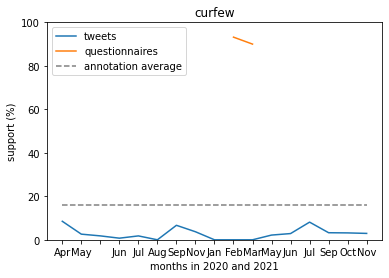

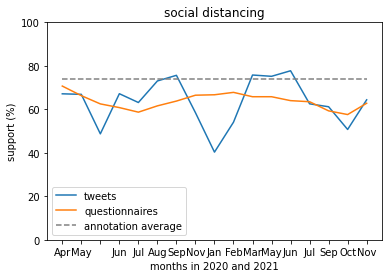

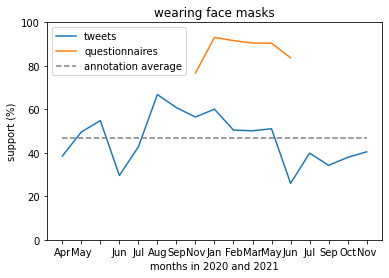

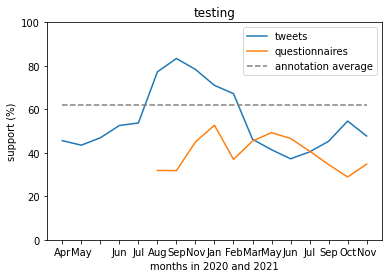

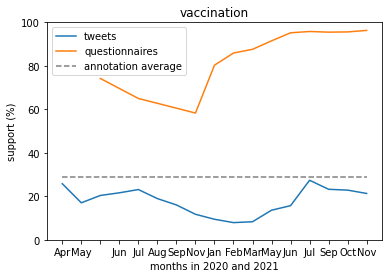

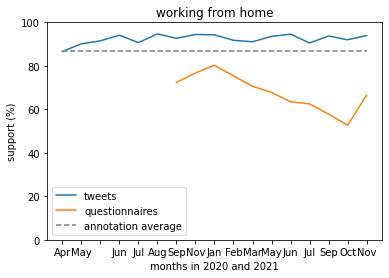

In [36]:
for topic in TOPICS:
    x, y, x_rivm, y_rivm = make_x_y(classifications, offsets, topic)
    plot_single(x, y, x_rivm, y_rivm, topic)

In [64]:
def plot_multi(ax, x, y, x_rivm, y_rivm, offsets, topic):
    ax.set_ylim(0, 100)
    ax.plot(x, y, label="tweets")
    ax.plot(x_rivm, y_rivm, label="questionnaires")
    ax.plot(x, [ support[topic] for i in x ], "--", color="grey", label="annotation average")
    ax.legend()
    ax.set_title(labels[topic])
    ax.set_xticks(x)
    x_labels = []
    for i in range(0, len(RIVM_MONTHS_ORG + RIVM_MONTHS)):
        if i % 3 == 0:
            x_labels.append((RIVM_MONTHS_ORG + RIVM_MONTHS)[i])
        else:
            x_labels.append("")
    ax.set_xticklabels(x_labels)
    ax.set_xlabel("months in 2020 and 2021")
    ax.set_ylabel("support (%)")

/home/erikt/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


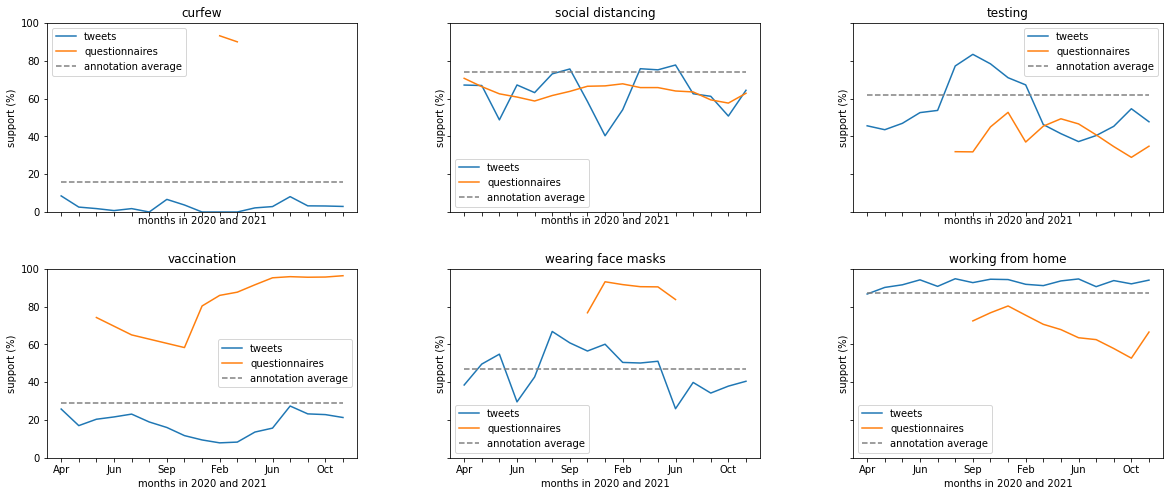

In [65]:
fig = plt.figure(figsize=(20,8))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
axes = gs.subplots(sharex='col', sharey='row')

for i in range(0, len(TOPICS)):
    topic = [TOPICS[0], TOPICS[1], TOPICS[3], TOPICS[4], TOPICS[2], TOPICS[5], ][i]
    axes_x = i % 3
    axes_y = int(i/3)
    x, y, x_rivm, y_rivm = make_x_y(classifications, offsets, topic)
    plot_multi(axes[axes_y, axes_x], x, y, x_rivm, y_rivm, offsets, topic)
fig.savefig(f"ieee.png")
fig.show()

## 4. Compare graphs

In [94]:
import numpy as np

In [95]:
def evaluate(x, y, x_rivm, y_rivm):
    data = { x[i]: y[i] for i in range(0, len(x)) }
    data_rivm = { x_rivm[i]: y_rivm[i] for i in range(0, len(x_rivm)) }
    differences = [ abs(data[key] - data_rivm[key]) for key in data_rivm ]
    delta =  np.average(differences)
    std = np.std(differences)
    r = np.corrcoef([data[i] for i in x_rivm], [data_rivm[i] for i in x_rivm])[0][1]
    return delta, std, r

In [96]:
for topic in TOPICS:
    x, y, x_rivm, y_rivm = make_x_y(classifications, offsets, topic)
    delta, std,r = evaluate(x, y, x_rivm, y_rivm)
    nbr_of_relevant_tweets = round(sum([classifications[topic][key]["total"] * 
                                        (classifications[topic][key]["__label__EENS"] + 
                                         classifications[topic][key]["__label__ONEENS"]) for key in classifications[topic]])/100)
    nbr_of_irrelevant_tweets = round(sum([classifications[topic][key]["total"] * classifications[topic][key]["__label__ANDERS"] for key in classifications[topic]])/100)
    nbr_of_tweets = sum([classifications[topic][key]["total"] for key in classifications[topic]])
    annotation_counts = pd.Series([ annotations[topic][key]["label"] for key in annotations[topic] ]).value_counts().to_dict()
    print(f"{topic:>14s}: delta: {round(delta)}±{round(std)}; r: {r:0.1f};", end=" ")
    print(f"tweets: total: {nbr_of_tweets}; relevant: {nbr_of_relevant_tweets} ({round((100*nbr_of_relevant_tweets)/(nbr_of_relevant_tweets+nbr_of_irrelevant_tweets))}%); irrelevant: {nbr_of_irrelevant_tweets}", 
          end=" ")
    print("annotation: relevant: " + str(round(100 * (annotation_counts["EENS"] + annotation_counts["ONEENS"])/len(annotations[topic]))) + "%", end=" ")
    print("support: " + str(round(100 * annotation_counts["EENS"]/(annotation_counts["EENS"] + annotation_counts["ONEENS"]))) + "%")

        curfew: delta: 92.0±2.0; r: nan; tweets: total: 76721; relevant: 19250 (25%); irrelevant: 57500 annotation: relevant: 27% support: 16%
      distance: delta: 9.0±6.0; r: 0.1; tweets: total: 287898; relevant: 212525 (74%); irrelevant: 75372 annotation: relevant: 76% support: 74%
     mondkapje: delta: 35.0±8.0; r: -0.2; tweets: total: 412394; relevant: 155383 (38%); irrelevant: 257018 annotation: relevant: 45% support: 47%
       testing: delta: 21.0±16.0; r: -0.2; tweets: total: 651992; relevant: 176288 (27%); irrelevant: 475613 annotation: relevant: 47% support: 62%
        vaccin: delta: 68.0±13.0; r: 0.2; tweets: total: 2235353; relevant: 577802 (26%); irrelevant: 1657676 annotation: relevant: 35% support: 29%
work-from-home: delta: 25.0±8.0; r: 0.2; tweets: total: 46067; relevant: 11864 (26%); irrelevant: 34213 annotation: relevant: 34% support: 87%


/home/erikt/anaconda3/envs/python37/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/erikt/anaconda3/envs/python37/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


| topic             |  tweets | relevant | annotated | relevant | support | time frame          | F     | delta          | r    |
| -----             |  ------ | -------- | --------- | -------- | ------- | ------------------- | ----- |--------------- | ---  |
| social distancing | 251,625 |      58% |     5,977 |      76% |     74% | Feb 2020 - Jul 2020 | 0.723 | 0.1&plusmn;0.1 | -0.3 |
| testing           | 124,392 |      28% |     1,181 |      47% |     62% | Mar 2020 - Dec 2020 | 0.496 | 0.1&plusmn;0.1 | -0.1 |
| work from home    |  37,486 |       9% |     1,003 |      34% |     87% | Mar 2020 - May 2021 | 0.492 | 0.1&plusmn;0.0 | -0.7 |
| vaccination       |  64,927 |      15% |     1,340 |      35% |     29% | Jan 2020 - May 2021 | 0.354 | 0.5&plusmn;0.1 | -0.0 |
| wearing facemasks |  98,702 |      23% |     1,011 |      45% |     47% | Mar 2020 - Mar 2021 | 0.472 | 0.5&plusmn;0.1 | -0.1 |
| curfew            |  62,843 |      14% |       750 |      27% |     16% | Mar 2020 - May 2021 | 0.413 | 0.8&plusmn;0.0 | -1.0 |
| social distancing | 204,574 |      47% |     1,186 |      75% |     72% | Feb 2020 - Jul 2020 | 0.685 | 0.1&plusmn;0.1 | -0.4 |

## 5. Get dates of annotated social distancing tweets 

In [ ]:
tweet_data = pd.read_csv(DATA_DIR + "distance-tweets.csv")
time_data = pd.read_csv("csv/first_tweet_ids.csv")

In [ ]:
months = {}
time_data_index = 0
for i, row in tweet_data.iterrows():
    while str(row["id_str"]) >= str(time_data.iloc[time_data_index+1]["id_str"]):
        time_data_index += 1
    while str(row["id_str"]) < str(time_data.iloc[time_data_index]["id_str"]):
        time_data_index -= 1
    if str(row["id_str"]) < str(time_data.iloc[time_data_index+1]["id_str"]) and str(row["id_str"]) >= str(time_data.iloc[time_data_index]["id_str"]):
        month = time_data.iloc[time_data_index]["file_name"].split("/")[8]
        if month not in months:
            months[month] = 0
        months[month] += 1
    else:
        print(f"cannot happen: {row['id_str']} {time_data_index} {time_data.iloc[time_data_index]['id_str']}")
        break
months

## 6. Evaluate fastText

In [ ]:
import sklearn

In [ ]:
def store_fasttext_data(annotations):
    _, path = tempfile.mkstemp()
    data_file = open(path, "w")
    for row in annotations:
        print(f'__label__{row["label"]} {preprocess(row["text"])}', file=data_file)
    data_file.close()
    return path

In [ ]:
def make_fasttext_model_np(annotations):
    path = store_fasttext_data(annotations)
    model = fasttext.train_supervised(path, dim=300, pretrainedVectors="twiqs-model-2020.vec")
    os.remove(path)
    return model

In [ ]:
def remove_label_prefix(label):
    return re.sub("__label__", "", label)

In [ ]:
topic = DISTANCE1000
predicted_labels = []
for train, test in sklearn.model_selection.KFold(n_splits=10).split(annotations[topic]):
    annotations_nparray = np.array([annotations[topic][key] for key in annotations[topic]])
    model = make_fasttext_model_np(annotations_nparray[train])
    test_data = [ row["text"] for row in annotations_nparray[test] ] 
    predicted_labels.extend(model.predict(test_data)[0])
    print("*", end="")       

In [ ]:
correct = 0
found = 0
target = 0
gold_labels = [ annotations[topic][key]["label"] for key in annotations[topic] ]
for i in range(0, len(predicted_labels)):
    if remove_label_prefix(predicted_labels[i][0]) != "ANDERS":
        if remove_label_prefix(predicted_labels[i][0]) == gold_labels[i]:
            correct += 1
        found += 1
    if gold_labels[i] != "ANDERS":
        target += 1
precision = correct/found
recall = correct/target
f = 2 * precision * recall / (precision + recall)
print(f"precision: {precision:0.3f}; recall: {recall:0.3f}; f: {f:0.3f}")

CURFEW: precision: 0.497; recall: 0.353; f: 0.413 \
DISTANCE: precision: 0.711; recall: 0.735; f: 0.723 \
DISTANCE1000: precision: 0.667; recall: 0.704; f: 0.685 \
FACEMASK: precision: 0.516; recall: 0.435; f: 0.472 \
TESTING: precision: 0.523; recall: 0.471; f: 0.496 \
VACCINATION: precision: 0.398; recall: 0.319; f: 0.354 \
WORKFROMHOME: precision: 0.544; recall: 0.449; f: 0.492

## 7. Classify with one user one vote

## 8. Optimize fastText parameters